In [46]:
import seaborn as sns
import numpy as np
import pandas as pd
import scipy as sc
import itertools

from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.weightstats import zconfint

from bootstrap_stat import bootstrap_stat as bp

from statsmodels.stats.proportion import proportion_confint, proportions_ztest, \
confint_proportions_2indep, test_proportions_2indep

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def permutation_t_stat_2s(sample1, sample2):
    return np.mean(sample1) - np.mean(sample2)

def get_random_combinations(n1, n2, max_permutations):
    index = np.array(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_permutations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

def permutation_null_dist_2s(sample1, sample2, max_permutations = None):
    pooled_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n2 = len(sample2)
    n = n1 + n2
    
    if max_permutations:
        indices = get_random_combinations(n1, n2, max_permutations)
    else:
        indices = [(list(index), filter(lambda i: i not in index, range(n))) \
                    for index in itertools.combinations(range(n), n1)]
    
    distr = [permutation_t_stat_2s(pooled_sample[list(i[0])], pooled_sample[list(i[1])]) \
             for i in indices]
    return distr

def permutation_test_2s(sample1, sample2, max_permutations = None, alternative = 'two-sided', return_distr = False):
    if alternative not in ('two-sided', 'less', 'greater'):
        raise ValueError("alternative not recognized\n"
                         "should be 'two-sided', 'less' or 'greater'")
    
    t_stat = permutation_t_stat_2s(sample1, sample2)
    
    null_distr = permutation_null_dist_2s(sample1, sample2, max_permutations)
    
    if alternative == 'two-sided':
        p = sum([1. if abs(x) >= abs(t_stat) else 0. for x in null_distr]) / len(null_distr)
    elif alternative == 'less':
        p = sum([1. if x <= t_stat else 0. for x in null_distr]) / len(null_distr)
    else: # alternative == 'greater':
        p = sum([1. if x >= t_stat else 0. for x in null_distr]) / len(null_distr)
    
    if return_distr:
        return {'t': t_stat, 'p': p, 'null_distr': null_distr}
    else:
        return {'t': t_stat, 'p': p}

In [12]:
def get_bootstrap_samples(x, n_resamples):
    indices = np.random.randint(0, len(x), (n_resamples, len(x)))
    resamples = x[indices]
    return resamples

In [13]:
def percentile_interval(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [48]:
def permutation_stat_cat_ind(sample1, sample2):
    ct = pd.crosstab(sample1, sample2)
    return stats.chi2_contingency(ct)[0]

def get_random_permutations(n, max_permutations):
    index = np.array(range(n))
    indices = set([tuple(index)])        
    for i in range(max_permutations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return list(indices)

def permutation_null_dist_cat_ind(sample1, sample2, max_permutations = None):
    if not len(sample1) == len(sample2):
        raise ValueError("Samples should be paired and have the same size")
        
    n = len(sample1)
    
    if max_permutations:
        indices = get_random_permutations(n, max_permutations)
    else:
        indices = list(itertools.permutations(list(range(n))))
    
    distr = [permutation_stat_cat_ind(sample1, sample2[list(i)]) for i in indices]
    return distr

def permutation_test_cat_ind(sample1, sample2, max_permutations = None, return_distr = False):    
    t_stat = permutation_stat_cat_ind(sample1, sample2)
    
    null_distr = permutation_null_dist_cat_ind(sample1, sample2, max_permutations)
    
    p = sum([1. if x >= t_stat else 0. for x in null_distr]) / len(null_distr)
        
    if return_distr:
        return {'t': t_stat, 'p': p, 'null_distr': null_distr}
    else:
        return {'t': t_stat, 'p': p}

In [52]:
def st_pearson_residuals(ct):
    e = stats.chi2_contingency(ct)[3]
    r = e
    n_plus_j = sum(ct, axis=0)
    n_i_plus = sum(ct, axis=1)
    n = sum(n_plus_j)
    for i in range(len(n_i_plus)):
        for j in range(len(n_plus_j)):
            r[i,j] = (ct.values[i,j] - e[i,j]) / np.sqrt(e[i,j] * (1 - n_i_plus[i] / n) * (1 - n_plus_j[j] / n))
    return pd.DataFrame(data=r, index = ct.index, columns = ct.columns)
    

In [3]:
data = pd.read_csv('test.csv')

In [4]:
data.head()

,ID,LIMIT_BAL,GENDER,EDUCATION,MARITAL,AGE,PAY_SEP,PAY_AUG,PAY_JUL,PAY_JUN,...,BILL_JUN,BILL_MAY,BILL_APR,PAY_SEP.1,PAY_AUG.1,PAY_JUL.1,PAY_JUN.1,PAY_MAY.1,PAY_APR.1,default
0,1,20000,2,2,1,24,2,2,0,0,...,0,0,0,0,689,0,0,0,0,1
1,2,120000,2,2,2,26,0,2,0,0,...,3272,3455,3261,0,1000,1000,1000,0,2000,1
2,3,90000,2,2,2,34,0,0,0,0,...,14331,14948,15549,1518,1500,1000,1000,1000,5000,0
3,4,50000,2,2,1,37,0,0,0,0,...,28314,28959,29547,2000,2019,1200,1100,1069,1000,0
4,5,50000,1,2,1,57,0,0,0,0,...,20940,19146,19131,2000,36681,10000,9000,689,679,0


In [5]:
data.columns

Index(['ID', 'LIMIT_BAL', 'GENDER', 'EDUCATION', 'MARITAL', 'AGE', 'PAY_SEP',
       'PAY_AUG', 'PAY_JUL', 'PAY_JUN', 'PAY_MAY', 'PAY_APR', 'BILL_SEP',
       'BILL_AUG', 'BILL_JUL', 'BILL_JUN', 'BILL_MAY', 'BILL_APR', 'PAY_SEP.1',
       'PAY_AUG.1', 'PAY_JUL.1', 'PAY_JUN.1', 'PAY_MAY.1', 'PAY_APR.1',
       'default'],
      dtype='object')

**Task 1. Credit limit: test whether there are differences between median credit limits of two groups.**

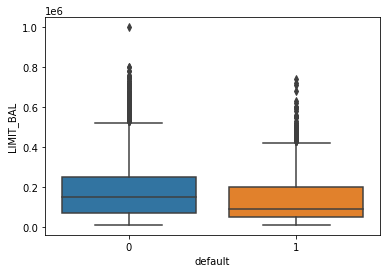

In [6]:
ax = sns.boxplot(x = 'default', y = 'LIMIT_BAL', data=data)

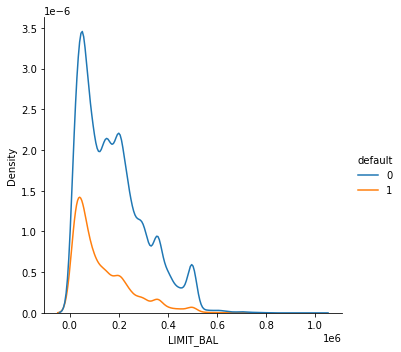

In [7]:
sns.displot(data, x = 'LIMIT_BAL', hue = 'default', kind = 'kde')

In [8]:
data.groupby('default')['LIMIT_BAL'].quantile(0.5)

default
0    150000.0
1     90000.0
Name: LIMIT_BAL, dtype: float64

In [33]:
data.groupby('default')['LIMIT_BAL'].quantile(0.5)[1]/data.groupby('default')['LIMIT_BAL'].quantile(0.5)[0]-1

-0.4

We have **two samples**, so we should use test for two independent samples. From the plot above we observe that samples come from **not normal distribution** so we should use non parametric tests. We have options: Mann-Whitney test or Permutation test. We know that permutation test preserve more information about samples. But it's computationally complex and we may use it with max_permutations limitation. To define confidence intervals for median differene between samples we may use bootstrap. 

X1 - credit limit for not defaulted customers

X2 - credit limit for defaulted customers

H0: Fx1(x) = Fx2(x) distributions of samples are equal

H1: Fx1(x) != Fx2(x)

In [29]:
print("Mann-Whitney test:", sc.stats.mannwhitneyu(data[data['default'] == 0]['LIMIT_BAL'], data[data['default'] == 1]['LIMIT_BAL']))

Mann-Whitney test: MannwhitneyuResult(statistic=59257217.5, pvalue=6.127742909111652e-190)


In [17]:
res = permutation_test_2s(data[data['default'] == 0]['LIMIT_BAL'], data[data['default'] == 1]['LIMIT_BAL'], max_permutations = 10000, return_distr = True)
print("Permutation test: t = %f, p = %f" % (res['t'], res['p']))

Permutation test: t = 47990.069655, p = 0.000100


In [27]:
defaulted_median_scores = list(map(np.median, get_bootstrap_samples(data[data['default'] == 0]['LIMIT_BAL'].values, 5000)))
notdefaulted_median_scores = list(map(np.median, get_bootstrap_samples(data[data['default'] == 1]['LIMIT_BAL'].values, 5000)))

print("Estimated difference between credit limit:", np.median(data[data['default'] == 0]['LIMIT_BAL']) - np.median(data[data['default'] == 1]['LIMIT_BAL']))

delta_median_scores = list(map(lambda x: x[1] - x[0], zip(defaulted_median_scores, notdefaulted_median_scores)))
print("95% confidence interval for the difference between median credit limit:",  
      percentile_interval(delta_median_scores, 0.05))

Estimated difference between credit limit: 60000.0
95% confidence interval for the difference between median credit limit: [-70000. -60000.]


As p_value of Permutation test < 0.05 we **reject H0**. We know that these samples come from different distribution and they have different medians. 
Defaulted customers credit limit median 40% lower than non-defaulted customers. The difference between medians is around [-70000. -60000.]$. **It's practically significant.**

**Task 2. Gender: test whether gender composition of two groups differ.**

<AxesSubplot:xlabel='GENDER', ylabel='count'>

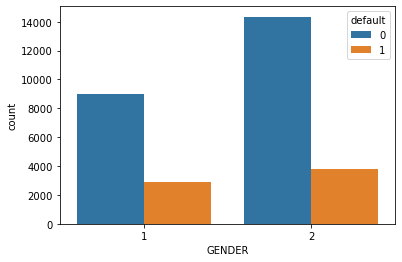

In [135]:
sns.countplot(data=data,x='GENDER',hue='default')

In [133]:
data.groupby(['GENDER', 'default'])['ID'].count()

GENDER  default
1       0           9015
        1           2873
2       0          14349
        1           3763
Name: ID, dtype: int64

We have **two samples** with distrubution of customers by gender, so we have proportions of each gender among group of defaulted customers and non-defaulted customers. We may use **Two proportions test for independent samples** to test their equality. 
Let's test proportion of women in two samles.

P1 - proportion of women in non-defaulted customers

P2 - proportions of women in defalted customers

H0: P1=P2

H1: P1 != P2 


In [44]:
print("P1 = ", 14349/(9015+14349))
print("P2 = ", 3763/(2873+3763))

P1 =  0.6141499743194658
P2 =  0.5670584689572031


In [47]:
print("Wilson's interval based test:", 
      test_proportions_2indep(14349, (9015+14349), 3763,(2873+3763), alternative = 'two-sided', 
                              method = 'score', correction=False, return_results=False))

print("Wald's interval:", confint_proportions_2indep(14349, (9015+14349), 3763,(2873+3763), method = 'wald', compare='diff'))

Wilson's interval based test: (6.921259731350102, 4.4764487319331085e-12)
Wald's interval: (0.03363493274962867, 0.060548077974896725)


In Wilson's interval based test p_value < 0.05, we **reject H0**. Proportions of women in non-defaulted customers is higher than in defaulted customers. The difference is around (0.03363493274962867, 0.060548077974896725) p.p. So gender composition of two groups differ. It's seems like not practically significant.

**Task 3. Education: test whether education levels differs between two groups. If it does, then how exactly?**

<AxesSubplot:xlabel='EDUCATION', ylabel='count'>

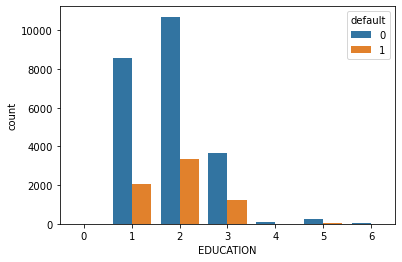

In [136]:
sns.countplot(data=data,x='EDUCATION',hue='default')

In [49]:
ct = pd.crosstab(data['default'], data['EDUCATION'])
ct

EDUCATION,0,1,2,3,4,5,6
default,,,,,,,
0,14,8549,10700,3680,116,262,43
1,0,2036,3330,1237,7,18,8


We have **two variables** with Education Level and binary indicator of a default. Both of them we may consider as categorical to make permutation test for independence of categorical variables. We need this test to understand if there is a relationship between these two variables. 

X1 - is_defaulted customers labels

X2 - education level labels

H0: X1 and X2 are independent

H1: H0 is False

In [51]:
from scipy import stats
res= permutation_test_cat_ind(data['default'].values, data['EDUCATION'].values, 
                              max_permutations = 10000, return_distr = True)
print("Permutation test: t = %f, p = %f" % (res['t'], res['p']))

Permutation test: t = 163.216558, p = 0.000100


We may see that p_value of Premitation test < 0.05, so there is difference between education levels of groups. To understand teh exact difference we may use **Two Proportons test for independent samples**.

P1i - proportion of level i customers among nondefaulted

P2i - proportion of level i customers among defaulted

Ho: P1i = P2i

H1: P1i != P2i

In [65]:
default = data.groupby('default')['ID'].count()
test = data.groupby(['default','EDUCATION' ])['ID'].count().reset_index()
nondefault_size = default[0]
default_size = default[1]
education_levels = set(data['EDUCATION'])

In [107]:
print("Z test:", test_proportions_2indep(0, default_size, 14, nondefault_size, alternative = 'two-sided',
                                          method = 'wald',  return_results=False))
print("P1 = ", 14/nondefault_size)
print("P2 = ", 0/default_size)
print("Wald's interval:", confint_proportions_2indep(0, default_size, 14, nondefault_size, method = 'wald', compare='diff'))

Z test: (-3.7427789146946226, 0.00018199634546898827)
P1 =  0.0005992124636192433
P2 =  0.0
Wald's interval: (-0.0009129993248122074, -0.0002854256024262791)


In [104]:
for level in range(1,7):
    print("Level = ", level)
    
    nondefault_level = test[(test['default'] == 0) & (test['EDUCATION'] == level)]['ID'].values[0]
    default_level = test[(test['default'] == 1) & (test['EDUCATION'] == level)]['ID'].values[0]
    
    print(nondefault_level, default_level)
    
    print("Wilson's interval based test:", 
      test_proportions_2indep(nondefault_level, nondefault_size, default_level, default_size, alternative = 'two-sided', 
                              method = 'score', correction=False, return_results=False))
    print("P1 = ", nondefault_level/nondefault_size)
    print("P2 = ", default_level/default_size)
    print("Wald's interval:", confint_proportions_2indep(nondefault_level, nondefault_size, default_level, default_size, method = 'wald', compare='diff'))

Level =  1
8549 2036
Wilson's interval based test: (8.890078676360108, 6.10656547696024e-19)
P1 =  0.36590481082006504
P2 =  0.30681133212778783
Wald's interval: (0.046394523643617125, 0.0717924337409373)
Level =  2
10700 3330
Wilson's interval based test: (-6.3162231669007065, 2.680329168621276e-10)
P1 =  0.4579695257661359
P2 =  0.5018083182640145
Wald's interval: (-0.05745982538725076, -0.030217759608506416)
Level =  3
3680 1237
Wilson's interval based test: (-5.612303581315207, 1.996507738117169e-08)
P1 =  0.15750727615134394
P2 =  0.18640747438215793
Wald's interval: (-0.03936972923406703, -0.01843066722756096)
Level =  4
116 7
Wilson's interval based test: (4.398874215496198, 1.0881386820949822e-05)
P1 =  0.004964903269988016
P2 =  0.0010548523206751054
Wald's interval: (0.002717467045698944, 0.005102634852926877)
Level =  5
262 18
Wilson's interval based test: (6.355722888873257, 2.0744870760859705e-10)
P1 =  0.011213833247731553
P2 =  0.0027124773960217
Wald's interval: (0.0066

Doctorate: proportion of customers with such education level among nondefaul customers (0.0002854256024262791, 0.0009129993248122074) p.p. **higher** that among default customers.(p_value < 0.05)

Masters: proportion of customers with such education level among nondefaul customers (0.046394523643617125, 0.0717924337409373) p.p. **higher** that among default customers.(p_value < 0.05)

Bachelor: proportion of customers with such education level among nondefaul customers (-0.05745982538725076, -0.030217759608506416) p.p. **lower** that among default customers.(p_value < 0.05)

School graduate: proportion of customers with such education level among nondefaul customers (-0.03936972923406703, -0.01843066722756096) p.p. **lower** that among default customers.(p_value < 0.05)

Elementary education: proportion of customers with such education level among nondefaul customers (0.002717467045698944, 0.005102634852926877) p.p. **higher** that among default customers.(p_value < 0.05)

Other: proportion of customers with such education level among nondefaul customers (0.0002854256024262791, 0.0009129993248122074) p.p. **higher** that among default customers.(p_value < 0.05)

There is no difference between groups by customers with no data. 

It's practically significant.

**Task 4.Marital status: Check how marital status is related to the default indicator: you need to propose a measure by which you can measure the possible relationship of these variables and calculate its value.**

MARITAL: marital status: 0 = no answer; 1 = married; 2 = single; 3 = no data. 

We have **two variables** with Marital Status and binary indicator of a default. Both of them we may consider as categorical to make permutation test for independence of categorical variables. We need this test to understand if there is a relationship between these two variables. 

X1 - is_defaulted customers labels

X2 - marital status level labels

H0: X1 and X2 are independent

H1: H0 is False

<AxesSubplot:xlabel='MARITAL', ylabel='count'>

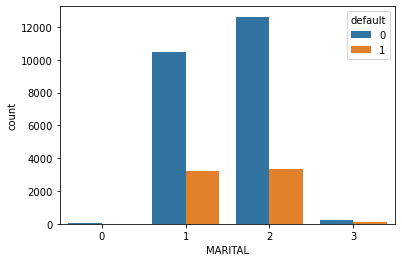

In [137]:
sns.countplot(data=data,x='MARITAL',hue='default')

In [109]:
ct = pd.crosstab(data['default'], data['MARITAL'])
ct

MARITAL,0,1,2,3
default,,,,
0,49,10453,12623,239
1,5,3206,3341,84


In [108]:
res= permutation_test_cat_ind(data['default'].values, data['MARITAL'].values, 
                              max_permutations = 10000, return_distr = True)
print("Permutation test: t = %f, p = %f" % (res['t'], res['p']))

Permutation test: t = 35.662396, p = 0.000100


We may see that p_value of Premitation test < 0.05, so there is difference between marital status of groups. To understand teh exact difference we may use **Two Proportons test for independent samples**.

P1i - proportion of level i customers among nondefaulted

P2i - proportion of level i customers among defaulted

Ho: P1i = P2i

H1: P1i != P2i

In [111]:
default = data.groupby('default')['ID'].count()
test = data.groupby(['default','MARITAL'])['ID'].count().reset_index()
nondefault_size = default[0]
default_size = default[1]
education_levels = set(data['MARITAL'])

for level in range(4):
    print("Level = ", level)
    
    nondefault_level = test[(test['default'] == 0) & (test['MARITAL'] == level)]['ID'].values[0]
    default_level = test[(test['default'] == 1) & (test['MARITAL'] == level)]['ID'].values[0]
    
    print(nondefault_level, default_level)
    
    print("Wilson's interval based test:", 
      test_proportions_2indep(nondefault_level, nondefault_size, default_level, default_size, alternative = 'two-sided', 
                              method = 'score', correction=False, return_results=False))
    print("P1 = ", nondefault_level/nondefault_size)
    print("P2 = ", default_level/default_size)
    print("Wald's interval:", confint_proportions_2indep(nondefault_level, nondefault_size, default_level, default_size, method = 'wald', compare='diff'))

Level =  0
49 5
Wilson's interval based test: (2.2789841746508346, 0.022668006048002617)
P1 =  0.0020972436226673516
P2 =  0.0007534659433393611
Wald's interval: (0.00046063549648618803, 0.002226919862169793)
Level =  1
10453 3206
Wilson's interval based test: (-5.157027848383254, 2.5090049917692524e-07)
P1 =  0.44739770587228217
P2 =  0.4831223628691983
Wald's interval: (-0.04933366293043459, -0.022115651063397662)
Level =  2
12623 3341
Wilson's interval based test: (5.303344616783128, 1.1369998690296422e-07)
P1 =  0.5402756377332648
P2 =  0.503465943339361
Wald's interval: (0.023187975579911483, 0.050431413207896125)
Level =  3
239 84
Wilson's interval based test: (-1.6918558872341205, 0.09067345461935598)
P1 =  0.010229412771785653
P2 =  0.012658227848101266
Wald's interval: (-0.005412027246568973, 0.0005543970939377485)


We can see that nondefaulted customers (0.00046063549648618803, 0.002226919862169793) p.p. often prefer not to specify their marilal status. Among them (0.023187975579911483, 0.050431413207896125) p.p. more single customers. So among defalted customers more married customers. There is no difference among group by no data labels.

**To measure possible relationship between marital status and default label** we may calculate mean value of marital status between defaulted and non-defalted users. We can think of this as an ordinal variable. We will leave only two values (1,2), the rest of the values are not numerous in the samples. Is sample mean of one group is higher than in this group number if single customers is higher. We know that distribution is not normal so we will use nonparametric tests.

X1 - marital status for not defaulted customers

X2 - marital status for defaulted customers

H0: Fx1(x) = Fx2(x) distributions of samples are equal

H1: Fx1(x) != Fx2(x)

In [116]:
test = data[data['MARITAL'].isin([1,2])]
test.groupby('default')['MARITAL'].mean()

default
0    1.547019
1    1.510310
Name: MARITAL, dtype: float64

We have two samples, so we should use test for two independent samples. From the plot above we observe that samples come from not normal distribution so we should use non parametric tests. We have options: Mann-Whitney test or Permutation test. We know that permutation test preserve more information about samples. But it's computationally complex and we may use it with max_permutations limitation. 

In [119]:
res = permutation_test_2s(data[data['default'] == 0]['MARITAL'], data[data['default'] == 1]['MARITAL'], max_permutations = 10000, return_distr = True)
print("Permutation test: t = %f, p = %f" % (res['t'], res['p']))

Permutation test: t = 0.030608, p = 0.000200


As p_value < 0.05 we can say that definetely in nindefaulted group tehre are more single customers. 

**Task 5.Age: test whether there are differences between mean ages of clients in two groups.**

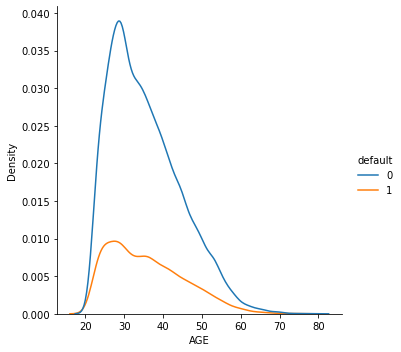

In [121]:
sns.displot(data, x = 'AGE', hue = 'default', kind = 'kde')

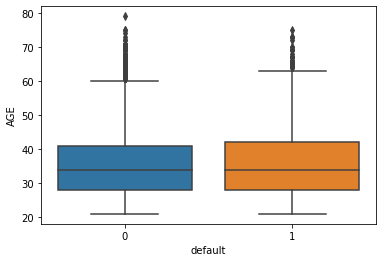

In [122]:
ax = sns.boxplot(x = 'default', y = 'AGE', data=data)

We have **two samples**, so we should use test for two independent samples. From the plot above we observe that samples come from **not normal distribution** so we should use non parametric tests. We have options: Mann-Whitney test or Permutation test. We know that permutation test preserve more information about samples. But it's computationally complex and we may use it with max_permutations limitation. To define confidence intervals for mean differene between samples we may use bootstrap. 

X1 - age for not defaulted customers

X2 - age for defaulted customers

H0: Fx1(x) = Fx2(x) distributions of samples are equal

H1: Fx1(x) != Fx2(x)

In [126]:
data.groupby('default')['AGE'].mean()

default
0    35.417266
1    35.725738
Name: AGE, dtype: float64

In [123]:
res = permutation_test_2s(data[data['default'] == 0]['AGE'], data[data['default'] == 1]['AGE'], max_permutations = 10000, return_distr = True)
print("Permutation test: t = %f, p = %f" % (res['t'], res['p']))

Permutation test: t = -0.308473, p = 0.017300


In [127]:
defaulted_mean_scores = list(map(np.mean, get_bootstrap_samples(data[data['default'] == 0]['AGE'].values, 5000)))
notdefaulted_mean_scores = list(map(np.mean, get_bootstrap_samples(data[data['default'] == 1]['AGE'].values, 5000)))

print("Estimated difference between neab age:", np.mean(data[data['default'] == 0]['AGE']) - np.mean(data[data['default'] == 1]['AGE']))

delta_mean_scores = list(map(lambda x: x[1] - x[0], zip(defaulted_mean_scores, notdefaulted_mean_scores)))
print("95% confidence interval for the difference between median credit limit:",  
      percentile_interval(delta_mean_scores, 0.05))

Estimated difference between neab age: -0.308472517494188
95% confidence interval for the difference between median credit limit: [0.04913799 0.58015333]


As p_value of Permutation test < 0.05 we **reject H0**. But it this case the **mean difference between group is not Practically significant**.